## Промежуточный проект karpov_courses. 

Выполняется в рамках прохождения курсов по специальности Аналитик Данных. Задания изложены по ходу документа, в общем виде это несколько конкретных вопросов, а также выполнение когортного анализа и создание RFM-сегментации.

Сами данные, по всей видимости, сгенерированные. Дополнительной информации по ним никакой нет, только та, что изложена в самих датасетах в формате комментариев при импорте, а также в теле вопросов. По этой причине многие тезисы и выводы по ходу анализа звучат довольно абстрактно и требуют уточнения.

In [1]:
# Импорт библиотек и ввод настроек
import pandas as pd
import numpy as np
import calendar
import datetime

import requests
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale = 1.5, style = 'whitegrid', rc = {'figure.figsize' : (20,8)})

#### Загрузка датасетов.

In [2]:
# customers - данные о пользователях.

# customer_id —  позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/aAArameeaz801g' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
customers = pd.read_csv(download_url)

print(customers.shape)
customers.head(2)

(99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [3]:
# orders - данные о заказах

# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/0w_jOM9-hz6opw' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
orders = pd.read_csv(download_url, 
    parse_dates = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date']
                       )
print(orders.shape)
orders.head(2)

(99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [4]:
# order_items - данные о товарах, входящих в заказы

# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/sBa2k2KahYCAIw' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
order_items = pd.read_csv(download_url, parse_dates = ['shipping_limit_date'])

print(order_items.shape)
order_items.head(2)

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


## Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:
### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

#### В первом приближении необходимо:
- выяснить, сколько заказов было сделано каждым пользователем;
- отсортировать тех пользователей, у кого это количество заказов равняется единице;
- подсчитать количество таких пользователей.

In [5]:
customers_with_num_orders = (orders
    .merge(customers, on = 'customer_id', how = 'inner', suffixes = ('orders_df', 'customers_df'))
    .groupby('customer_unique_id', as_index = False)
    .agg({'order_id':'count'})
    .rename(columns = {'order_id':'number_of_orders'})
                            )
print('Количество пользователей с одним заказом - ',
      customers_with_num_orders.query('number_of_orders == 1').shape[0])               

Количество пользователей с одним заказом -  93099


Корректно ли говорить о том, что данное количество - это количетсво покупок? 

Есть подозрения, что нет. Для начала, проверим, все ли заказы оплачены.

In [6]:
print('Количество заказов без оплаты -',
      orders.isna().sum().order_approved_at)

Количество заказов без оплаты - 160


   Получается, что часть оплат еще не была проведена. Такие заказы считать "покупками" преждевременно, так как клиент может передумать оплачивать заказ, или же внести корректировки в счет и в таком случае возможен случай создания нового заказа и отмены текущего и т.п. Поэтому считаю, что данные заказы необходимо из расчета исключить.
    
Также проверим текущие статусы заказов:

In [7]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

По статусам заказов ясно, что некоторые из них "в работе" - происходит отгрузка, доставка и т.д. Так как факт оплаты мы учли выше, вызывают подозрения только статусы "canceled" и "unavailable". Посмотрим на них внимательней:

In [8]:
orders.query('order_status == "canceled" or order_status == "unavailable"').tail(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15
99415,5fabc81b6322c8443648e1b21a6fef21,32c9df889d41b0ee8309a5efb6855dcb,unavailable,2017-10-10 10:50:03,2017-10-14 18:35:57,NaT,NaT,2017-10-23


Мы видим, что некоторые из этих заказов даже оплачены, и учитывая только факт оплаты, мы их воспринимаем как завершенные. Сложно однозначно утверждать, что случилось с этими заказами. Однако даже если оплата была проведена, полноценной "покупкой" данный заказ считать осмотрительно. Предположу что в тех случаях, где заказ "отменен" или "недоступен", а оплата была произведена - полученные денежные средства будут или уже были возвращены пользователю.

Оба вышеуказанных тезиса необходимо уточнить у продакт-менеджера Василия. Но так как Василий сейчас недоступен, сочту свои предположения разумными и внесу коррективы в первоначальный расчет, приняв во внимания факт оплаты и статусы заказов.

In [9]:
customers_with_true_num_orders = (orders
    .fillna(0)
    .query('order_approved_at != 0')
    .query('order_status != "canceled" and order_status != "unavailable"')
    .merge(customers, on = 'customer_id', how = 'inner', suffixes = ('orders_df', 'customers_df'))
    .groupby('customer_unique_id', as_index = False)
    .agg({'order_id':'count'})
    .rename(columns = {'order_id':'number_of_orders'})
                                  )
print('Количество пользователей с одним валидным заказом - ',
      customers_with_true_num_orders.query('number_of_orders == 1').shape[0])     

Количество пользователей с одним валидным заказом -  92087


### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

##### Для ответа на вопрос необходимо:
- отсортировать данные о заказах без заказов со статусом "достевлен";
- сгруппировать заказы по статусам;
- аггрегировать группы заказов по месяцам;
- построить визуализацию.

Для начала определим, сколько заказов не было доставлено и какая это часть от общего числа заказов:

In [10]:
not_delivered_orders = (orders
    .query('order_status !="delivered"')
                       )
print("Всего не доставлено заказов - ", not_delivered_orders.shape[0],',', sep = '')
print("это", round(not_delivered_orders.shape[0] / orders.shape[0], 2), '% от общего числа заказов.')

Всего не доставлено заказов - 2963,
это 0.03 % от общего числа заказов.


На первый взгляд число небольшое.
Посмотрим на эти заказы с группировкой по статусам:

In [11]:
not_delivered_orders_by_status = (not_delivered_orders
    .groupby('order_status')
    .agg({'order_id' : 'count'})
    .rename(columns = {'count' : 'num_orders_by_status'})
                                 )
not_delivered_orders_by_status

,order_id
order_status,
approved,2
canceled,625
created,5
invoiced,314
processing,301
shipped,1107
unavailable,609


Статусы логично разделить на 2 группы:
- 1 группа - заказы, находящиеся "в работе". К этим статусам отнесем: "approved", "created", "invoiced", "processing", "shipped".
- 2 группа - "проблемные" заказы. К этим статусам отнесем "canceled" и "unavailable"

Василий не дал однозначной установки, какие конкретно заказы он имеет ввиду. Однако приравнивать заказы из первой группы к заказам из второй группы некорректно. 

Заказы из первой группы не доставлены на момент выгрузки датасета, однако вполне вероятно что некоторые из них доставлены в момент обработки данных. И даже если нет - эти заказы находятся на разных стадиях процесса оформления заказа или доставки, проще говоря - они "живые".

Заказы же из второй группы с большой вероятностью как были не доставлены на момент выгрузки данных, так и не доставлены на момент обработки данных. Предпологаю, что это либо "застрявшие" в производственном процессе заказы, либо вовсе "мертвые" заказы.

Велика вероятность, что Василий имел ввиду именно вторую группу заказов. Однако, на всякий случай, сделаем отчет не только по заказам по месяцам целиком, но и с разбивкой по двум указанным группам. 

Обработаем датафрейм, добавив дату в формате "год-месяц" и принадлежность к группам. "Живые" заказы обобщим статусом "in_process", а "мертвые" - статусом "problem". За дату, отвечающую за разбивку по месяцам, возьмем дату формирования заказа. 

In [12]:
# Создаю колонку с данными о дате создания заказа в формате год-месяц.
not_delivered_orders['year_month'] = not_delivered_orders.order_purchase_timestamp.dt.strftime('%Y-%m')

# Создаю функцию для преобразования статуса заказа.
def make_additional_status(x):
    if x in ['unavailable','canceled']:
        x = 'problem'
    else:
        x = 'in_progress'
    return x

# Создаю колонку с дополнительным статусом в соответствии с новой логикой группировки.
not_delivered_orders['additional_status'] = not_delivered_orders.order_status.apply(make_additional_status)

not_delivered_orders.head(2)                   

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,additional_status
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04,in_progress
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06,in_progress


Сначала посмотрим на общие данные, без новых статусов:

In [13]:
not_delivered_orders_all = (not_delivered_orders
    .groupby('year_month', as_index = False)
    .agg({'order_id': 'count'})
    .rename(columns = {'order_id' : 'count_orders'})
    .sort_values('year_month') 
                                    )
not_delivered_orders_all

,year_month,count_orders
0,2016-09,3
1,2016-10,59
2,2017-01,50
3,2017-02,127
4,2017-03,136
5,2017-04,101
6,2017-05,154
7,2017-06,110
8,2017-07,154
9,2017-08,138


Делать выводы по данному датафрейму затруднительно и может быть опрометчиво, в том числе по причинам, описанным выше. Однако он позволяет получить первое число - среднее значение **всех недоставленных заказов** в месяц. Также заметим, что всего месяцев в расчете - 24. Сохраним это число в переменную, оно понадобится для корректного рассчета в дальнейшем.

Также добавим диаграмму для удобства восприятия.


Среднее количество всех недоставленных заказов в месяц -  123.46 



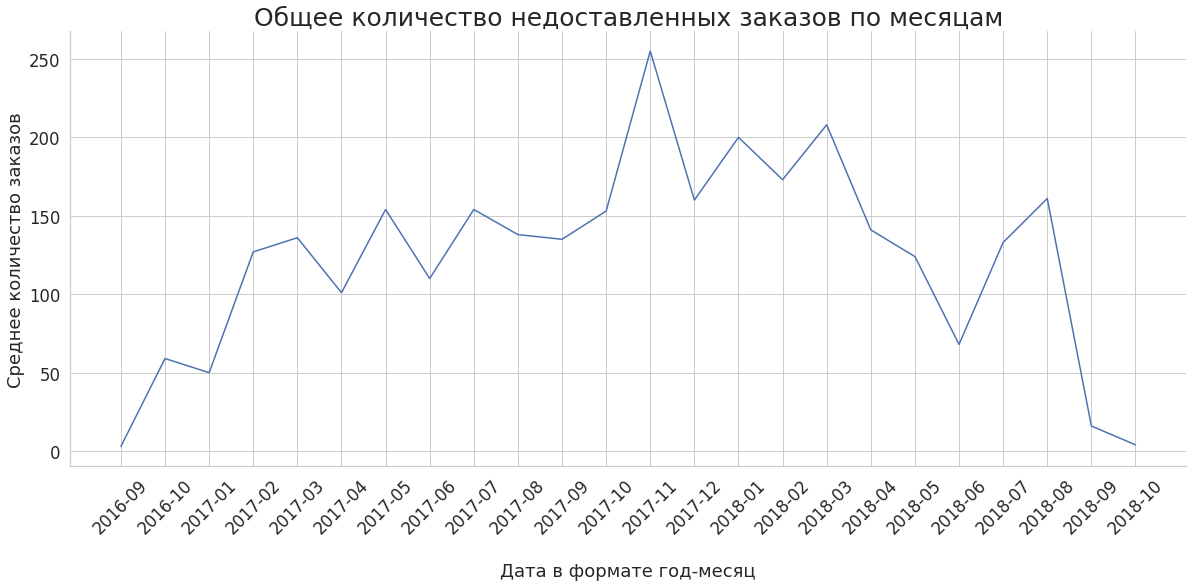

In [14]:
total_months = not_delivered_orders_all.shape[0]
total_avg = round(not_delivered_orders_all.count_orders.mean(),2)

print('\nСреднее количество всех недоставленных заказов в месяц - ', total_avg, '\n')

ax = sns.lineplot(x = 'year_month', y = 'count_orders', data = not_delivered_orders_all)
ax.set_title('Общее количество недоставленных заказов по месяцам', fontsize = 25)
ax.set_xlabel('\nДата в формате год-месяц')
ax.set_ylabel('Среднее количество заказов')
plt.xticks(rotation=45)
sns.despine()

Рассмотрим заказы со статусом "in_progress"

In [15]:
not_delivered_orders_in_progress = (not_delivered_orders
    .query('additional_status == "in_progress"')
    .groupby('year_month', as_index = False)
    .agg({'order_id': 'count'})
    .rename(columns = {'order_id' : 'count_orders'})
    .sort_values('year_month') 
                                    )
not_delivered_orders_in_progress

,year_month,count_orders
0,2016-09,1
1,2016-10,28
2,2017-01,37
3,2017-02,65
4,2017-03,71
5,2017-04,74
6,2017-05,94
7,2017-06,70
8,2017-07,74
9,2017-08,79


Высчитаем среднее значение и создадим визуализацию для удобства восприятия:


Среднее количество недоставленных заказов со статусом "in_progress" в месяц - 72.04 



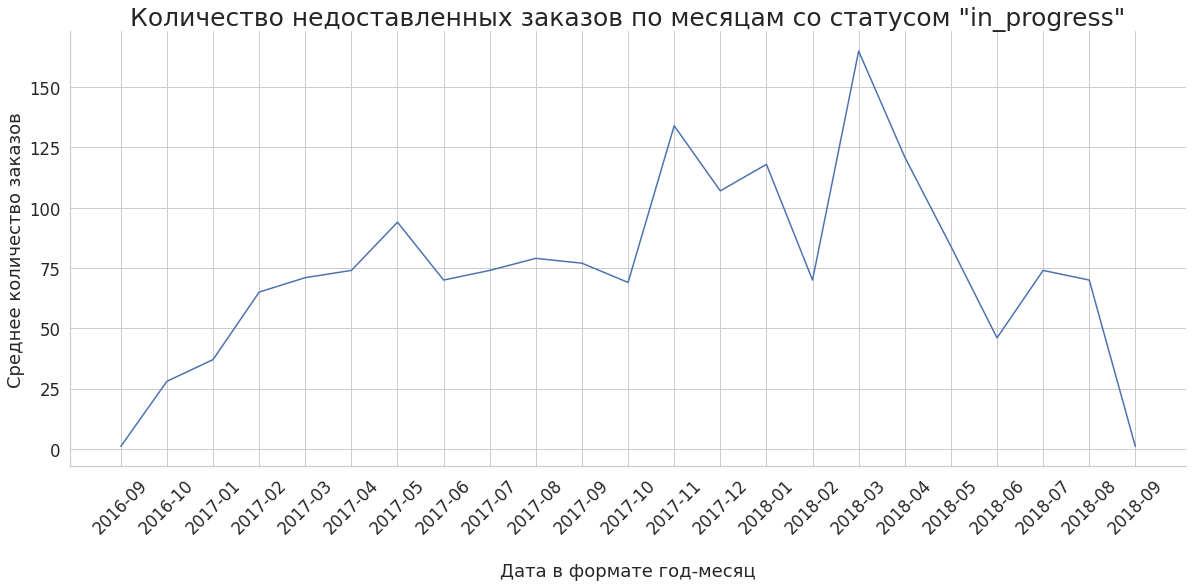

In [16]:
total_in_progress_avg =  round(not_delivered_orders_in_progress.count_orders.sum()/total_months,2)

print('\nСреднее количество недоставленных заказов со статусом "in_progress" в месяц -',
   total_in_progress_avg, '\n')
bx = sns.lineplot(x = 'year_month', y = 'count_orders', data = not_delivered_orders_in_progress)
bx.set_title('Количество недоставленных заказов по месяцам со статусом "in_progress"', fontsize = 25)
bx.set_xlabel('\nДата в формате год-месяц')
bx.set_ylabel('Среднее количество заказов')
plt.xticks(rotation=45)
sns.despine()

Вот здесь уже есть о чем подумать. Предполагая, что сейчас конец 2018-го года (было бы здорово :-( ), некоторые заказы "в работе" уже около двух лет. 

Откуда возникают такие заказы? Это доставка сложных товаров в удаленные регионы со сложной логистикой, то есть существование таких заказов - часть производственного процесса? Или это разморозившиеся старые заказы, которые недавно вернулись к жизни, но в связи со спецификой хранения данных они выглядят как крайне длительные? Или среди этих заказов есть уже "мертвые", но у них не актуальный статус?. 

Также некоторые вопросы возникают от формы распределения. В частности можно заметить 2 пика в районе 2017-11 и 2018-03. Какова причина такого большого количества не закрытых заказов именно в этих промежутках? Был глобальный прирост заказов и эта картина - естественное следствие этого прироста? Или же скажем какой-то конкретный менеджер не закрыл свои заказы в этом периоде?

Причин существования подобных заказов может быть множество. Также нельзя забывать о том, что среди них есть и вполне обычные заказы, где всё проходит в регламетные сроки. По старым заказам, вероятно Василию следует задать вопрос в отделы логистики и/или продаж. А по хорошему, эти данные сначала также нужно обработать и внимательней изучить - вычислить некоторые временные промежутки, детальней поработать со статусами и т.п., прежде чем поднимать этот вопрос с другими отделами. Сохраним эти данные в отдельную переменную, чтобы при необходимости быстро к ним вернуться.

In [17]:
not_delivered_orders_in_progress_for_vasiliy = (not_delivered_orders
    .query('additional_status == "in_progress"')
    .sort_values('order_purchase_timestamp')
                                               )

Аналогичным образом рассмотрим проблемные позиции

In [18]:
not_delivered_orders_with_problems = (not_delivered_orders
    .query('additional_status == "problem"')
    .groupby('year_month', as_index = False)
    .agg({'order_id': 'count'})
    .rename(columns = {'order_id' : 'count_orders'})
    .sort_values('year_month') 
                                    )
not_delivered_orders_in_progress

,year_month,count_orders
0,2016-09,1
1,2016-10,28
2,2017-01,37
3,2017-02,65
4,2017-03,71
5,2017-04,74
6,2017-05,94
7,2017-06,70
8,2017-07,74
9,2017-08,79



Среднее количество недоставленных заказов со статусом "problem" в месяц - 51.42 



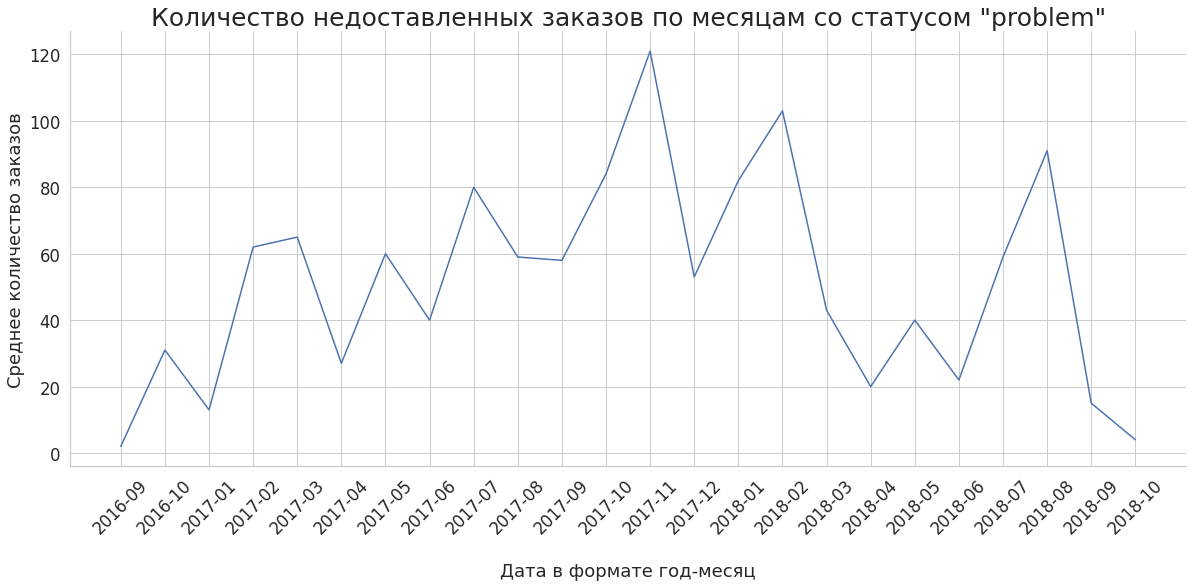

In [19]:
total_with_problems_avg = round(not_delivered_orders_with_problems.count_orders.sum()/total_months,2)

print('\nСреднее количество недоставленных заказов со статусом "problem" в месяц -',
   total_with_problems_avg, '\n')
bx = sns.lineplot(x = 'year_month', y = 'count_orders', data = not_delivered_orders_with_problems)
bx.set_title('Количество недоставленных заказов по месяцам со статусом "problem"', fontsize = 25)
bx.set_xlabel('\nДата в формате год-месяц')
bx.set_ylabel('Среднее количество заказов')
plt.xticks(rotation=45)
sns.despine()

В проблемных объектах причин возникновения задержек может быть больше, чем в обычных заказах. Для анализа этих данных нужно также подробней изучать как сами данные, так и логику формирования статусов "unavailable" и "canceled". 

Сейчас можно обратить внимание на 2 вещи. 

Форма данного графика также говорит о скачкообразом характере распределения. При этом количество этих скачков и их частота не говорят напрямую скажем о сезонности спроса, по крайней мере на первый взгляд. Проще говоря, также нужно обратить внимание на определенные месяца.

И еще одно наблюдение, которое можно сделать прямо сейчас. Когда мы говорим о 0.03 % недоставленных заказов от общего числа заказов, может интутивно показаться, что это некоторые отмененные или проблемные заказы. Однако как мы можем видеть по полученным данным, наши заказы застревают не только в "мертвых" статусах, но и во вполне себе "живых". Что в общем-то снова говорит о том, что нужно детальней разбираться с данными заказами.

Сохраним и эту группу заказов для дальнейшей обработки, а также сделаем короткую версию ответа на поставленный вопрос.

In [20]:
not_delivered_orders_with_problems_for_vasiliy = (not_delivered_orders
    .query('additional_status == "problem"')
    .sort_values('order_purchase_timestamp')
                                               )

In [21]:
if total_avg == round(total_in_progress_avg + total_with_problems_avg, 2):
    print('Среднее количество всех недоставленных заказов в месяц                         -',
        total_avg,' - ', '  100 %')
    print('Среднее количество недоставленных заказов со статусом "in_progress" в месяц    - ',
        total_in_progress_avg,' - ', round(100*total_in_progress_avg/total_avg,2),'%')
    print('Среднее количество недоставленных заказов со статусом "problem" в месяц        - ',
        total_with_problems_avg,' - ', round(100*total_with_problems_avg/total_avg,2),'%')
else:
    print('ERROR')

Среднее количество всех недоставленных заказов в месяц                         - 123.46  -    100 %
Среднее количество недоставленных заказов со статусом "in_progress" в месяц    -  72.04  -  58.35 %
Среднее количество недоставленных заказов со статусом "problem" в месяц        -  51.42  -  41.65 %


### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

Для ответа на этот вопрос, определимся с тем, какую дату будем считать за дату покупки. Судя по структуре данных, оплата производится после формирования заказа и выставления счета. Соответственно кандидатов на дату два - дата формирования заказа и дата оплаты выставленного счета. 

Предположу что Василий хочет увидеть некоторую взаимосвязь между спросом на определенный товар и днём недели. В этом случае отталкиваться от даты оплаты счета бессмысленно, так как это никак не отображает паттерны потребительского поведения - счет могли например выставить на день позже, пользователь мог оплатить его на день позже и т.п.. Поэтому за дату, из которой мы будем извлекать день недели, логично взять дату формирования заказа.

Также полезно помнить о том, что часть заказов нужно из расчета исключить. Так как речь идет именно о купленных товарах, здесь, напротив, опираться только на факт попадания товара в заказ может быть некорректно. С учетом увиденной картины в вопросе №2, думаю что убрать все заказы, кроме заказов со статусом "delivered", будет в данном случае уместно. Ведь даже если клиент некий отмененный или очень давний заказ оплатил - с большой вероятностью либо уже был, либо буде осуществлен возврат денежных средств. Ну и мы помним о том, что объем заказов вне статуса "delivered" равняется 0,03%, так что ожидать сильных изменений в данных не приходится.

##### Для ответа на вопрос необходимо:

- извлечь день недели из даты формирования каждого заказа;
- дополнить информацию о купленных товарах днем недели формирования заказа;
- для каждого товара посчитать, сколько раз он попал в заказ в каждый из дней недели;
- вывести товар и тот день недели, в который он пользовался максимальным спросом.

In [22]:
products_with_days_of_week = (order_items
    .merge(orders, on = 'order_id', how = 'inner', suffixes = ('oi_t','o_t'))
                       )
products_with_days_of_week['day_name'] = products_with_days_of_week.order_purchase_timestamp.dt.day_name()
products_with_days_of_week = (products_with_days_of_week
    .query('order_status == "delivered"')
    .groupby(['product_id', 'day_name'])
    .agg({'order_id':'count'})
    .rename(columns = {'order_id':'quantity'})
    .sort_values('quantity',ascending=False)
                       )
products_with_days_of_week.head(5)

quantity
product_id                       day_name           
422879e10f46682990de24d770e7f83d Wednesday        93
99a4788cb24856965c36a24e339b6058 Monday           91
aca2eb7d00ea1a7b8ebd4e68314663af Thursday         89
                                 Tuesday          85
                                 Friday           83

Данный дф содержит в себе ответ на заданный вопрос. Осталось лишь вывести его в более удобной форме.

Здесь возникает диллема. С одной стороны, можно вывести только первый по сортировке день, в который товар лучше всего продается. Но тогда мы можем упустить другой день, в который товар продается с таким же количественным значением. С другой стороны, если мы выведем топ-2 дня по продажам по данному продукту, эта информация может быть избыточной и вообще может не подойти для той задачи, которую Василий планирует выполнять с нашими данными.

Однозначного понимания, как именно нужно подготовить информацию, в вопросе не содержится. Поэтому подготовим ответ в формате - самый успешный день по продажам, но также сделаем удобную для обработки таблицу со всеми значениями продаж по дням, чтобы при необходимости в данный вопрос можно было погрузиться детальней.

In [23]:
products_with_top_sales_day = (products_with_days_of_week
    .reset_index()
    .sort_values('quantity',ascending=False)
    .groupby('product_id')
    .head(1)
                              )
products_with_top_sales_day.head(5)

,product_id,day_name,quantity
0,422879e10f46682990de24d770e7f83d,Wednesday,93
1,99a4788cb24856965c36a24e339b6058,Monday,91
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
8,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12,389d119b48cf3043d311335e499d9c6b,Thursday,67


In [24]:
products_with_days_of_week_pivot = products_with_days_of_week
products_with_days_of_week_pivot = (products_with_days_of_week_pivot
    .reset_index()
    .pivot(index = 'product_id', columns = 'day_name', values = 'quantity')
    .fillna(0)
    .reindex(columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
                                           )

products_with_days_of_week_pivot['max'] = products_with_days_of_week_pivot.max(axis = 1)
products_with_days_of_week_pivot.sort_values('max', ascending = False)

day_name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,max
product_id,,,,,,,,
422879e10f46682990de24d770e7f83d,64.0,67.0,93.0,79.0,77.0,57.0,47.0,93.0
99a4788cb24856965c36a24e339b6058,91.0,59.0,63.0,70.0,74.0,59.0,61.0,91.0
aca2eb7d00ea1a7b8ebd4e68314663af,78.0,85.0,72.0,89.0,83.0,59.0,54.0,89.0
53b36df67ebb7c41585e8d54d6772e08,57.0,76.0,45.0,46.0,38.0,29.0,30.0,76.0
368c6c730842d78016ad823897a372db,50.0,63.0,52.0,58.0,67.0,44.0,54.0,67.0
...,...,...,...,...,...,...,...,...
62a183c5f3895060ba1a8f1415694908,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
62a068fa5b6d1cb8015c754504a10bfa,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
629beb8e7317703dcc5f35b5463fd20e,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


Завершая тему, хочу заметить, что при постановке вопроса "самый успешный день недели для продукта", значения одного или двух дней с максимальными продажами определенного товара могут привести к неправильным выводам.

Рассмотрим подробней товар с product_id aca2eb7d00ea1a7b8ebd4e68314663af.

In [25]:
sample = products_with_days_of_week_pivot.reset_index().sort_values('max', ascending = False)
sample = sample[sample.product_id == 'aca2eb7d00ea1a7b8ebd4e68314663af']
sample = sample[['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']]
sample = sample.reset_index().drop(columns = 'index').T.reset_index()
sample

,day_name,0
0,Monday,78.0
1,Tuesday,85.0
2,Wednesday,72.0
3,Thursday,89.0
4,Friday,83.0
5,Saturday,59.0
6,Sunday,54.0


Мы видим максимальное значение продаж данного продукта в четверг. Однако данный продукт пользуется большим спросом и в остальные будние дни. Также для данного продукта может быть логичным уменьшение покупок по выходным - просто потому что люди меньше занимаются деловыми вопросами в выходные.

Иными словами, по данному продукту можно сделать вывод, что если корреляция между будним днем недели и покупкой данного продукта существует, то она невелика. А при выводе топ-дня недели по продажам этого товара мы можем создать впечатление о том, что данная корреляция существует и имеет весомое значение.

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
##### Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Честно говоря, я в большом недоумении от того, какую мягко говоря странную задачу поставил Василий. Может он прислал нам не те или не все датасеты? Или он имел ввиду метрику по каждому продукту, а не по каждому покупателю? Иначе какой смысл создавать метрику в проекте, где подавляющее большинство покупаетелей сделали всего по одному заказу?

Но надо - значит надо. Определимся с сутью метрики. Она должна отображать отношение количества товаров, приобретенных в конкретный месяц, к количеству недель в данном месяце. При этом количество недель должно определяться не датами начала или конца недели, а количеством дней внутри данного месяца. И даннную метрику необходимо вычислить по каждому пользователю. Нарекаем новую метрику IPW - Items Per Week. 

##### Для ответа на вопрос необходимо:
- Объединить данные о покупках с данными о клиентах;
- Отфильтровать заказы со статусом 'delivered' в соответствие с ранее сделанными выводами;
- Для каждой даты оформления заказа выявить год, номер месяца, а также добавить к дф информацию о количестве дней в этой паре год-месяц;
- Аггрерировать данные по количеству заказов для каждого пользователя в каждом месяце
- Вычислить значение метрики для каждой пары пользователь-месяц.



In [26]:
# Объединим нужные данные. Отфильтруем нужные заказы. Удалим лишние колонки.
IPW = (order_items
    .merge(orders, on = 'order_id', how = 'inner', suffixes = ('order_items_df', 'orders_df'))
    .merge(customers, on = 'customer_id', how = 'inner', suffixes = ('merged_df', 'customers_df'))
    .query('order_status == "delivered"')
       )
IPW = IPW.drop(columns = {'seller_id',
                            'shipping_limit_date',
                            'price','freight_value',
                            'customer_id','order_status',
                            'order_approved_at',
                            'order_delivered_carrier_date',
                            'order_delivered_customer_date',
                            'order_estimated_delivery_date',
                            'customer_zip_code_prefix',
                            'customer_city',
                            'customer_state'})
# Создадим колонку в формате год-месяц, а также другие вспомогательные колонки для работы с датой.
IPW['year_month'] = IPW.order_purchase_timestamp.dt.strftime('%Y-%m')
IPW['year'] = IPW['order_purchase_timestamp'].dt.year
IPW['month'] = IPW['order_purchase_timestamp'].dt.month
IPW['days_in_month'] = IPW.apply(lambda IPM: calendar.monthrange(IPM.year, IPM.month)[1], axis=1)
IPW

,order_id,order_item_id,product_id,order_purchase_timestamp,customer_unique_id,year_month,year,month,days_in_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,2017-09,2017,9,30
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,2017-04,2017,4,30
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,2018-01,2018,1,31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,2018-08,2018,8,31
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,2017-02,2017,2,28
...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,2018-04,2018,4,30
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,2018-07,2018,7,31
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,2017-10,2017,10,31
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,2017-08,2017,8,31


In [27]:
#Преобразуем дф 
IPW = (IPW
    .groupby(['customer_unique_id','year_month','days_in_month'])
    .agg({'order_item_id' : 'sum'})
    .rename(columns = {'order_item_id':'sum_items_by_month'})
    .sort_values('customer_unique_id')
    .reset_index() 
      )
IPW

,customer_unique_id,year_month,days_in_month,sum_items_by_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,31,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,31,1
2,0000f46a3911fa3c0805444483337064,2017-03,31,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,31,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,30,1
...,...,...,...,...
95189,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,30,3
95190,fffea47cd6d3cc0a88bd621562a9d061,2017-12,31,1
95191,ffff371b4d645b6ecea244b27531430a,2017-02,28,1
95192,ffff5962728ec6157033ef9805bacc48,2018-05,31,1


In [28]:
# Создадим колонку с метрикой, уберем выполнившие свою задачу колонки.
IPW['IPW'] = round(IPW.sum_items_by_month / (IPW.days_in_month / 7), 4)
IPW = IPW.drop(columns = {'days_in_month','sum_items_by_month'})
IPW

,customer_unique_id,year_month,IPW
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.2258
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.2258
2,0000f46a3911fa3c0805444483337064,2017-03,0.2258
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.2258
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.2333
...,...,...,...
95189,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.7000
95190,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.2258
95191,ffff371b4d645b6ecea244b27531430a,2017-02,0.2500
95192,ffff5962728ec6157033ef9805bacc48,2018-05,0.2258


Данный дф содержит в себе ответ на поставленный вопрос, при этом в нем нет лишней информации. Однако воспринимать такой дф может быть не удобно из-за неоднородности данных - пользователи совершали покупки в разные месяцы и в разное количество месяцев (хотя бы некоторые из них). Поэтому, как мне кажется, результат нужно выдать в форме таблицы, где каждому пользователю соответсвует одна строка. Пусть это выглядит странно при текущих данных, но такой формат вывода данных позволит делать дальнейшие выводы - считать среднее значение по месяцам, а также высчитывать показатели конкретного пользователя или группы пользователей.

In [29]:
IPW_pivot = (IPW
    .pivot(index = 'customer_unique_id', columns = 'year_month', values = 'IPW')
            )
IPW_pivot

year_month,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2258,NaN,NaN,NaN
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2258,NaN,NaN,NaN
0000f46a3911fa3c0805444483337064,NaN,NaN,NaN,NaN,NaN,0.2258,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000f6ccb0745a6a4b88665a16c9f078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0004aac84e0df4da2b147fca70cf8255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fffea47cd6d3cc0a88bd621562a9d061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffff371b4d645b6ecea244b27531430a,NaN,NaN,NaN,NaN,0.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5. Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

Определим ряд параметров для когортного анализа.
- Анализируемый показатель - retention.
- Основа (событие) для формирования когорт. В наших данных нет информации о том, как часто пользователь возвращался на наш сайт или открывал наше мобильное приложение (если таковые вообще есть). Поэтому фактом удержания клиента, определяющим метрику retention, мы можем считать только повторное оформление заказа пользователем в другом временном интервале.
- Исследуемый временной интервал. В задании явно не указан год, за который необходимо проводить анализ. Однако из решенных ранее заданий мы знаем, что в нашем датасете период формирования заказов - от 2016-09 до 2018-10. Это значит, что единственный интервал, попадающий под формулировку - "с января по декабрь" - это 2017 год, Соответственно, исследуемая аудитория -  пользователи, сделавшие свой первый заказ в 2017-м году. 
- Принцип формирования когорт. За признак группировки пользователей в когорты возьмем месяц, в который пользователем был оформлен первый заказ.

Также помним, что заказы со статусами, отличными от статуса "delivered" из расчета лучше исключить, в силу причин, описанных выше.

##### Для проведения когортного анализа необходимо:
- Отобрать заказы по 2017-му году;
- Определить пользователей, совершивших первую покупку в течение 2017-го года;
- Каждому пользователю присвоить номер когорты согласно месяцу первого заказа;
- Сфомировать датафрейм для расчета retention;
- Визуализировать retention.

Получив результаты когортного анализа для каждой группы пользователей по каждому месяцу, будем решать конкретную задачу о значениях retentoin на третий месяц для каждой когорты.

In [30]:
# Создадим базовый дф, в котором будут данные о пользователях и их заказах.
customers_with_orders_all = (customers
    .merge(orders, on = 'customer_id', how = 'inner')
       )
customers_with_orders_all = customers_with_orders_all.query('order_status == "delivered"')
customers_with_orders_all['year'] = customers_with_orders_all['order_purchase_timestamp'].dt.year
customers_with_orders_all = customers_with_orders_all.drop(columns = {'customer_id',
                                                                      'customer_zip_code_prefix',
                                                                      'customer_city',
                                                                      'customer_state',
                                                                      'order_status',
                                                                      'order_approved_at',
                                                                      'order_delivered_carrier_date',
                                                                      'order_delivered_customer_date',
                                                                      'order_estimated_delivery_date'})
customers_with_orders_all.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,year
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018


In [31]:
# Определим пользователей, совершивших покупку в 2017-м году. 

customers_with_orders_in_2017 = (customers_with_orders_all
    .query('year == 2017')
                                )
customers_with_orders_in_2017.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,year
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31,2017


Далее возможны варианты. Среди этих пользователей могут быть такие, которые уже совершали у нас покупку ранее 2017 года. Их можно воспринимать в рамках данного анализа как новых пользователей (например, если у нас сильно изменились продукты или условия их предоставления), так и как уже "удержанных" (в рамках термина retention) пользователей, которые вернулись совершить еще один заказ. Так как на первый вариант ничего не указывает, считаю корретным, что пользователей, совершивших заказ в 2016 году, из когортного анализа 2017 года необходимо убрать.

In [32]:
# Определим пользователей, совершавших заказы в 2016 году

customers_with_orders_in_2016 = (customers_with_orders_all
    .query('year == 2016')
                                )
customers_with_orders_in_2016.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,year
347,99e41e69b60bd63edd83935499523063,8213bc96304fc0881189c4525f3002f7,2016-10-10 07:53:34,2016
386,3c34090736785a45dd8cbf536ad289c4,3379d980824f0aa5dab057f2530759bb,2016-10-10 16:39:37,2016


In [33]:
# Объединим датафреймы, чтобы исключить из аудитории 2017-го года пользователей с первым заказом в 2016-м году.

customers_with_orders_in_2017 = customers_with_orders_in_2017.merge(customers_with_orders_in_2016, on = 'customer_unique_id', how = 'left', suffixes = ('_df_2017', '_df_2016'))

# Проверим, нашлись ли вообще такие пользователи.
print('Количиество уникальных пользователей, совершивших покупку первую покупку в 2016 году, а затем совершивших покупку в 2017 году - ', 
      customers_with_orders_in_2017
      .fillna(0)
      .query('order_id_df_2016 != 0')
      .customer_unique_id
      .value_counts()
      .shape[0])
customers_with_orders_in_2017.fillna(0).query('order_id_df_2016 != 0')

Количиество уникальных пользователей, совершивших покупку первую покупку в 2016 году, а затем совершивших покупку в 2017 году -  5


,customer_unique_id,order_id_df_2017,order_purchase_timestamp_df_2017,year_df_2017,order_id_df_2016,order_purchase_timestamp_df_2016,year_df_2016
211,0b3dc7efaafb0cf78a4796d42fa8d74c,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,2017-07-28 09:34:29,2017,60762802b48bb6d256d55b013d115013,2016-10-04 14:49:13,2016.0
8293,f7b981e8a280e455ac3cbe0d5d171bd1,ec7a019261fce44180373d45b442d78f,2017-01-05 11:56:06,2017,bd50a7fe9fd97ea4b7663031a319e150,2016-12-23 23:16:47,2016.0
29881,4962136f755981b83b03f476e66eea7d,dff8b1ccb6e61a785f9fad1cd48df4af,2017-11-11 16:13:40,2017,89f586f0cbddc6428831c41c8c333c66,2016-10-09 12:46:25,2016.0
30167,8329519e31cb1b89bd44c3c6ae417ad6,777ee9fd50fbe50e788ef536b1656b08,2017-04-10 21:29:16,2017,2825848807f070485f0f0ef3829758f4,2016-10-09 22:36:44,2016.0
36941,32ea3bdedab835c3aa6cb68ce66565ef,30ae6774935cd2a70fa74306f407495b,2017-09-27 08:20:09,2017,3b697a20d9e427646d92567910af6d57,2016-10-03 09:44:50,2016.0


Пользователи, совершившие первую покупку в 2016-м году, нашлись среди пользователей, совершивших покупку в 2017-м году. Исключим их заказы из анализа заказов 2017 года.

In [34]:
# Убираем лишних пользователей и лишние колонки.

customers_with_orders_in_2017 = (customers_with_orders_in_2017
    .fillna(0)
    .query('order_id_df_2016 == 0')
    .drop(columns = {'order_id_df_2016',
                     'order_purchase_timestamp_df_2016',
                     'year_df_2016'})
                                )
customers_with_orders_in_2017 = (customers_with_orders_in_2017
    .rename(columns = {'order_id_df_2017' : 'order_id', 
                       'order_purchase_timestamp_df_2017' : 'order_purchase_timestamp', 
                       'year_df_2017' : 'year'}))
customers_with_orders_in_2017.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,year
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31,2017


Мы получили дф, в котором есть информация по заказам пользователей, оформивших первый заказ в 2017-м году. При этом в данном дф могут быть и повторные заказы тех же самых пользователей. Выясним, сколько уникальных пользователей попадает в наш когортный анализ.

In [35]:
# Определим уникальных пользователей и их количество.
unique_customers_2017 = customers_with_orders_in_2017.customer_unique_id.unique()
unique_customers_2017 = pd.DataFrame(unique_customers_2017, columns = ['customer_unique_id_2017'])
number_unique_customers_2017 = unique_customers_2017.shape[0]
print('Количество уникальных пользователей с первым заказом в 2017-м году -',number_unique_customers_2017)
unique_customers_2017

Количество уникальных пользователей с первым заказом в 2017-м году - 42131


,customer_unique_id_2017
0,861eff4711a542e4b93843c6dd7febb0
1,4c93744516667ad3b8f1fb645a3116a4
2,57b2a98a409812fe9618067b6b8ebe4f
3,2a7745e1ed516b289ed9b29c7d0539a5
4,918dc87cd72cd9f6ed4bd442ed785235
...,...
42126,277490f0d435b602fe4475d4b89e9181
42127,e7f8760e2bbd2f1986bebd99596c088e
42128,4b5820135d360a45552b5163835b1d89
42129,73c2643a0a458b49f58cea58833b192e


In [36]:
# Создадим столбец с месяцами заказов.
customers_with_orders_in_2017['month'] = customers_with_orders_in_2017['order_purchase_timestamp'].dt.month

# Создадим дф с количеством заказов каждого пользователя.
customers_with_number_of_orders_in_2017 = (customers_with_orders_in_2017
    .groupby('customer_unique_id', as_index = False)
    .agg({'order_id' : 'count'})
    .rename(columns = {'order_id' : 'number_of_orders'})                                       
         )
customers_with_number_of_orders_in_2017.head(2)

# Объединим основной дф с полученным выше.
customers_with_orders_in_2017 = (customers_with_orders_in_2017
    .merge(customers_with_number_of_orders_in_2017, on = 'customer_unique_id', how = 'inner')                                
                                )
customers_with_orders_in_2017

,customer_unique_id,order_id,order_purchase_timestamp,year,month,number_of_orders
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017,5,1
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31,2017,9,2
2,4c93744516667ad3b8f1fb645a3116a4,98b737f8bd00d73d9f61f7344aadf717,2017-10-15 12:44:13,2017,10,2
3,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:29:02,2017,11,1
4,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 17:23:20,2017,11,1
...,...,...,...,...,...,...
43418,277490f0d435b602fe4475d4b89e9181,326c29ec5b89834b17aea7d85302fd70,2017-05-24 11:54:31,2017,5,1
43419,e7f8760e2bbd2f1986bebd99596c088e,ec3a75fb0ac595e461765d2d854b1d08,2017-03-15 21:04:08,2017,3,1
43420,4b5820135d360a45552b5163835b1d89,c9aea907527f5d4f5fb44955c18a79fb,2017-12-17 23:13:41,2017,12,1
43421,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,2017,11,1


Пользователей в данном дф можно разделить на 2 категории: 

- 1. Пользователи, оформившие в 2017-м году только один заказ.
- 2. Пользователи, оформившие в 2017-м году больше одного заказа.

Для первой категории номер когорты будет равен номеру месяца, в котором они совершили свой единственный заказ.

Для второй категории номер когорты будет равен номеру того месяца, в котором они совершили свой первый за 2017-й год заказ. При этом важно понимать, что в наших данных могут быть такие пользователи, которые совершили более одного заказа, но все эти заказы были совершены в одном месяце. В таком случае пользователь в рамках метрики retention с делением на когорты по месяцам не будет считаться "удержанным".

Здесь (а на самом деле намного раньше) было бы уместно подумать о том, насколько корректно подобран временной интервал для разделения пользователей на когорты. Ведь если пользователь оформил повторный заказ спустя две недели после оформления первого заказа, и оба этих заказа попали в один календарный месяц - насколько корректно говорить о том, что пользователь "никуда не уходил" и не был нами "удержан"? 

Но так как Василий в задании сформулировал свой вопрос в месяцах, будем считать что этот временной интервал согласован и признан корректным.

In [37]:
# Создадим отдельный датафрейм с customer_unique_id и номерами когорт.
# Соберем его из двух частей, присвоив номера когорт отдельно первой и второй категории.

# Первая категория
first_cathegory = (customers_with_orders_in_2017
    .query('number_of_orders == 1')
    .drop(columns = {'order_id','order_purchase_timestamp','year','number_of_orders'})
    .rename(columns = {'month' : 'cohort_index'})
                  )
first_cathegory

,customer_unique_id,cohort_index
0,861eff4711a542e4b93843c6dd7febb0,5
3,57b2a98a409812fe9618067b6b8ebe4f,11
4,2a7745e1ed516b289ed9b29c7d0539a5,11
5,918dc87cd72cd9f6ed4bd442ed785235,9
6,7f3a72e8f988c6e735ba118d54f47458,5
...,...,...
43418,277490f0d435b602fe4475d4b89e9181,5
43419,e7f8760e2bbd2f1986bebd99596c088e,3
43420,4b5820135d360a45552b5163835b1d89,12
43421,73c2643a0a458b49f58cea58833b192e,11


In [38]:
# Вторая категория.
second_cathegory = customers_with_orders_in_2017.query('number_of_orders != 1')

# Сгруппируем данные по customer_unique_id, аггрегировав по минимальному значению месяца для каждого пользователя.
second_cathegory = (second_cathegory
    .groupby('customer_unique_id', as_index = False)
    .agg({'month' : 'min'})
    .rename(columns = {'month' : 'cohort_index'})
                   )
second_cathegory

,customer_unique_id,cohort_index
0,00cc12a6d8b578b8ebd21ea4e2ae8b27,3
1,013f4353d26bb05dc6652f1269458d8d,11
2,015557c9912277312b9073947804a7ba,3
3,01c289bb06354cdc7e6549570f20ada4,6
4,02168ea18740a0fdaaa15f11bebba5db,8
...,...,...
1165,fed2005ccab4fcf1a40ebdaff032a148,6
1166,ff44401d0d8f5b9c54a47374eb48c1b8,5
1167,ff8892f7c26aa0446da53d01b18df463,5
1168,ff922bdd6bafcdf99cb90d7f39cea5b3,2


In [39]:
# Объединим датафреймы.

customers_and_cohort = (pd.concat([first_cathegory, second_cathegory])
    .sort_values('cohort_index')
    .reset_index()
    .drop(columns = {'index'})
                       )

# Проверим, что количество пользователей в новом дф сходится с первоначальными данными.
if customers_and_cohort.shape[0] == customers_with_orders_in_2017.customer_unique_id.nunique():
    print('Датафрейм сформирован корретно.')
else:
    print('!!!ERROR!!!')
customers_and_cohort

Датафрейм сформирован корретно.


,customer_unique_id,cohort_index
0,f78a1d6281b3b4a1542c00bd1d8b503a,1
1,8704d22470c90667b52c6fb875625418,1
2,30ad1451a70a8da11a69dc6dcfe31256,1
3,59d70280e586b9af0a548f9e0fe68cae,1
4,ef89f6e31311594d74becf9e18c73693,1
...,...,...
42126,66cdade9593087e4d54912e755e8b61f,12
42127,b2cacb795265383fd4d96ad26461cd2c,12
42128,667fca0b2400a9bc057a0824080bcf6a,12
42129,d469ff90bd1e879cdfed08343ac1a77c,12


In [40]:
cohorts_size = (customers_and_cohort
    .groupby('cohort_index', as_index = False)
    .agg({'customer_unique_id':'count'})
    .rename(columns = {'customer_unique_id':'cohort_size'})
               )
cohorts_size

,cohort_index,cohort_size
0,1,717
1,2,1628
2,3,2503
3,4,2256
4,5,3451
5,6,3037
6,7,3752
7,8,4057
8,9,4004
9,10,4328


In [41]:
# Присвоим номера когорт заказам в основном датафрейме.

customers_with_orders_in_2017 = customers_with_orders_in_2017.merge(customers_and_cohort, on = 'customer_unique_id', how = 'inner')

# Проверим что все данные внесены корректно
if customers_with_orders_in_2017.query('cohort_index == 0').shape[0] == 0:
    print('Датафрейм сформирован корретно.')
else:
    prine('!!!ERROR!!!')
customers_with_orders_in_2017

Датафрейм сформирован корретно.


,customer_unique_id,order_id,order_purchase_timestamp,year,month,number_of_orders,cohort_index
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017,5,1,5
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31,2017,9,2,9
2,4c93744516667ad3b8f1fb645a3116a4,98b737f8bd00d73d9f61f7344aadf717,2017-10-15 12:44:13,2017,10,2,9
3,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:29:02,2017,11,1,11
4,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 17:23:20,2017,11,1,11
...,...,...,...,...,...,...,...
43418,277490f0d435b602fe4475d4b89e9181,326c29ec5b89834b17aea7d85302fd70,2017-05-24 11:54:31,2017,5,1,5
43419,e7f8760e2bbd2f1986bebd99596c088e,ec3a75fb0ac595e461765d2d854b1d08,2017-03-15 21:04:08,2017,3,1,3
43420,4b5820135d360a45552b5163835b1d89,c9aea907527f5d4f5fb44955c18a79fb,2017-12-17 23:13:41,2017,12,1,12
43421,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,2017,11,1,11


Все данные для когортного анализа готовы. Для начала построим анализ в абсолютных значениях - посмотрим, сколько колличественно мы "удержали" пользователей из каждой когорты в каждом месяце.

In [42]:
# Создаем список с названиями колонок
columns = ['2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11', '2017-12']

# Создаем список с номерами когорт.
index = cohorts_size.cohort_index.tolist()

# Создаем список списков с количеством пользователей каждой когорты, совершивших заказ в каждом месяце.
# Внешний цикл - определяет номер рассматриваемой когорты.
# Внутренний цикл - определяет количество пользователей, совершивших заказ в каждом из месяцев. 

data = []
for i in range(1,13):
    k = []
    for j in range(1,13):
        k.append(
            customers_with_orders_in_2017
                .query('cohort_index == {}'.format(i))
                    .query('month == {}'.format(j))
                        .customer_unique_id
                            .nunique()
                )
        j +=1
    data.append(k)
    i += 1

analys_1 = pd.DataFrame(data, index, columns)
analys_1 = (analys_1
    .reset_index()
    .rename(columns = {'index':'cohort_index'})
    .merge(cohorts_size, on = 'cohort_index', how = 'inner')
    .set_index('cohort_index')
           )

analys_1 = analys_1[['cohort_size',
                     '2017-01',
                     '2017-02',
                     '2017-03',
                     '2017-04',
                     '2017-05',
                     '2017-06',
                     '2017-07',
                     '2017-08',
                     '2017-09',
                     '2017-10',
                     '2017-11', 
                     '2017-12']]
analys_1

,cohort_size,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_index,,,,,,,,,,,,,
1,717,717,2,2,1,3,1,3,1,1,0,3,1
2,1628,0,1628,3,5,2,7,2,4,3,2,3,2
3,2503,0,0,2503,11,9,10,9,4,4,8,8,2
4,2256,0,0,0,2256,14,5,4,6,6,8,7,7
5,3451,0,0,0,0,3451,16,16,10,10,11,14,5
6,3037,0,0,0,0,0,3037,15,12,13,9,12,11
7,3752,0,0,0,0,0,0,3752,20,13,9,11,8
8,4057,0,0,0,0,0,0,0,4057,28,14,11,14
9,4004,0,0,0,0,0,0,0,0,4004,28,22,11


Как можно заметить, количество удержанных пользователей в каждой когорте не слишком велико. Снова остается надеятся на то, что нам прислали не все данные, и наш retention все же выше указанных значений.

Кстати о retention - пора составить такую же таблицу для него.

In [43]:
data = []
for i in range(1,13):
    k = []
    for j in range(1,13):
        k.append(
                round(100 * (customers_with_orders_in_2017
                    .query('cohort_index == {}'.format(i))
                        .query('month == {}'.format(j))
                            .customer_unique_id
                                .nunique()
                            ) 
                                / 
                            (
                customers_with_orders_in_2017
                    .query('cohort_index == {}'.format(i))
                            .customer_unique_id
                                .nunique()
                            )
                      ,5)
                )
        j +=1
    data.append(k)
    i += 1

analys_2 = pd.DataFrame(data, index, columns)
analys_2 = (analys_2
    .reset_index()
    .rename(columns = {'index':'cohort_index'})
    .merge(cohorts_size, on = 'cohort_index', how = 'inner')
    .set_index('cohort_index')
           )

analys_2 = analys_2[['cohort_size',
                     '2017-01',
                     '2017-02',
                     '2017-03',
                     '2017-04',
                     '2017-05',
                     '2017-06',
                     '2017-07',
                     '2017-08',
                     '2017-09',
                     '2017-10',
                     '2017-11', 
                     '2017-12']]
analys_2

,cohort_size,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_index,,,,,,,,,,,,,
1,717,100.0,0.27894,0.27894,0.13947,0.41841,0.13947,0.41841,0.13947,0.13947,0.00000,0.41841,0.13947
2,1628,0.0,100.00000,0.18428,0.30713,0.12285,0.42998,0.12285,0.24570,0.18428,0.12285,0.18428,0.12285
3,2503,0.0,0.00000,100.00000,0.43947,0.35957,0.39952,0.35957,0.15981,0.15981,0.31962,0.31962,0.07990
4,2256,0.0,0.00000,0.00000,100.00000,0.62057,0.22163,0.17730,0.26596,0.26596,0.35461,0.31028,0.31028
5,3451,0.0,0.00000,0.00000,0.00000,100.00000,0.46363,0.46363,0.28977,0.28977,0.31875,0.40568,0.14489
6,3037,0.0,0.00000,0.00000,0.00000,0.00000,100.00000,0.49391,0.39513,0.42805,0.29635,0.39513,0.36220
7,3752,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000,0.53305,0.34648,0.23987,0.29318,0.21322
8,4057,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000,0.69017,0.34508,0.27114,0.34508
9,4004,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000,0.69930,0.54945,0.27473


Данные в таком виде может быть удобно обрабатывать, но не удобно воспринимать. Создадим визуализацию для retention rate.

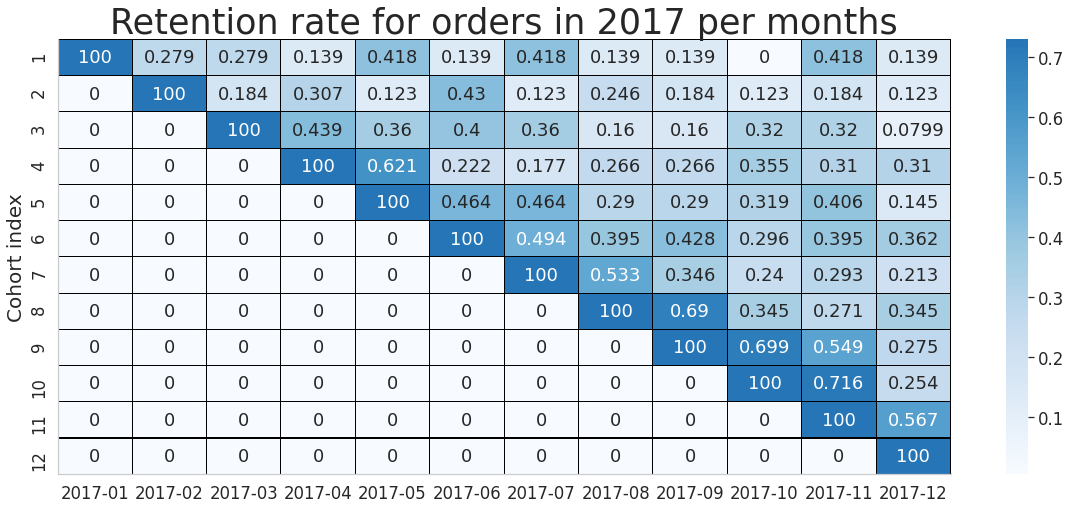

In [44]:
analys_3 = analys_2.reset_index().drop(columns = {'cohort_index','cohort_size'})
analys_3.index = [1,2,3,4,5,6,7,8,9,10,11,12]
cx = sns.heatmap(analys_3,
                 fmt ='.3g',
                 annot=True,
                 linewidths=.15,
                 vmax=.73, 
                 vmin=.005,
                 center=0.50,
                 cmap= 'Blues',
                 linecolor='black'
                )
cx.set_title('Retention rate for orders in 2017 per months', fontsize= 35)
cx.set_ylabel('Cohort index',fontsize= 20)
sns.despine()

Вернемся непосредственно к заданному Василием вопросу, определим когорту с наибольшим retention на 3-й месяц в период с января по декабрь. При рассмотрении метрики в рамках исключительно 2017-го года, у когорт с номерами 11 и 12 данный показатель определить не получится, ведь их "удержание" третьего месяца календарно попадает на 2018-й год.  

Не очевидно, ожидает ли Василий от нас проверку показателя, не входящего в указанный им временной промежуток. Поэтому отчет мы оставим без изменений, всё же он корректно отображает выбранный временной период, однако в ручном режиме вычислим значение retention в январе 2018 года для когорты 11 и значение retention в феврале 2018 года для когорты 12.

In [45]:
# Когорта 11.
# Отберем пользователей, зафиксируем их количество.

cohort_11 = (customers_with_orders_in_2017
    .query('cohort_index == 11')
    .drop(columns = {'order_id','order_purchase_timestamp','year','month','number_of_orders','cohort_index'})
    .drop_duplicates()
            )
cohort_11_size = cohort_11.shape[0]
cohort_11

,customer_unique_id
3,57b2a98a409812fe9618067b6b8ebe4f
4,2a7745e1ed516b289ed9b29c7d0539a5
7,3e6fd6b2f0d499456a6a6820a40f2d79
12,4d221875624017bc47b4d1ce7314a5b7
14,bf4862777db128507e9efcc789215e9b
...,...
43403,c6f8e1db66045b7e49203b47b5ce816f
43409,065b9e6198f11dbdf7fc1250f9e08afc
43415,4452b8ef472646c4cc042cb31a291f3b
43417,82d46759af0369aad49084bacf85a6c3


In [46]:
# Когорта 12.
# Отберем пользователей, зафиксируем их количество.

cohort_12 = (customers_with_orders_in_2017
    .query('cohort_index == 12')
    .drop(columns = {'order_id','order_purchase_timestamp','year','month','number_of_orders','cohort_index'})
    .drop_duplicates()
            )
cohort_12_size = cohort_12.shape[0]
cohort_12

,customer_unique_id
19,5ad58a4e6a1a656b6bed070cadbaa003
28,c3293e875ffb1116018edf76d24e52a2
31,76b029c87118a29f2e3de420f5ec2fa2
33,b436a108536c1dabbc1d3e808d782df9
40,694cb45ff29b603ac2acd51016770097
...,...
43401,e7122d936e3c5028c45df3228671cda9
43408,6667649dc575c65058507349be078d4f
43410,c64ede6d0ae8901b1b6fb03528c1b7e6
43420,4b5820135d360a45552b5163835b1d89


In [47]:
# Создадим дф с заказами в январе и феврале 2018-го года.
customers_with_orders_2018_jan_feb = customers_with_orders_all
customers_with_orders_2018_jan_feb['month'] = customers_with_orders_2018_jan_feb['order_purchase_timestamp'].dt.month
customers_with_orders_2018_jan_feb.query('month == 1 or month == 2')

,customer_unique_id,order_id,order_purchase_timestamp,year,month
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018,1
6,addec96d2e059c80c30fe6871d30d177,36e694cf4cbc2a4803200c35e84abdc4,2018-02-19 14:38:35,2018,2
8,1175e95fb47ddff9de6b2b06188f7e0d,1ebeea841c590e86a14a0d7a48e7d062,2018-01-18 12:35:44,2018,1
9,9afe194fb833f79e300e37e580171f22,7433cbcc783205509d66a5260da5b574,2018-01-08 11:22:34,2018,1
11,2a46fb94aef5cbeeb850418118cee090,f86c5ed7048ac10eb88ec21c00f71892,2018-02-07 11:36:42,2018,2
...,...,...,...,...,...
99412,3cc6f2e1b9199837fabb35ff4bf24884,ab042583eff2cb1ffe2110a95da95d4b,2018-01-22 12:02:21,2018,1
99417,522e244a96d13876c5bac4985a8d5075,1a9543c90f188e2e4fb14327ad4a9c9b,2018-01-30 15:28:21,2018,1
99418,b96d6a178adbabf269fd843b37327798,357b4b724bbf34f1d64b1c5dfdc88120,2018-01-24 02:22:12,2018,1
99420,1c137fe37df712015f6488edafe8ece4,b7ae7c643ef9274727f48dcb0ba08593,2017-01-25 16:51:27,2017,1


In [48]:
# Вычислим retention для когорты 11 на третий месяц.

print('Retention для когорты 11 на третий месяц -',
        round(
                (100 * customers_with_orders_2018_jan_feb.query('month == 1')
                                              .merge(cohort_11, on = 'customer_unique_id', how = 'inner')
                                              .shape[0] 
                                              / 
                                              cohort_11_size
                )
          ,5)
,'%')
print('Retention для когорты 12 на третий месяц -',
        round(
                (100 * customers_with_orders_2018_jan_feb.query('month == 2')
                                              .merge(cohort_12, on = 'customer_unique_id', how = 'inner')
                                              .shape[0] 
                                              / 
                                              cohort_12_size
                  )
          ,5)
,'%')

Retention для когорты 11 на третий месяц - 0.38244 %
Retention для когорты 12 на третий месяц - 0.29974 %


По полученным ранее данным мы видим, что наивысший показатель retention на третий месяц имеет когорта № 9 со значением в 0.54945 %. Так как мы проверили, что когорты 11 и 12 не превзошли этот впечатляющий результат в 2018-м году, мы можем смело отправить это значение Василию.

### 6. Используя python, построй RFM-сегментацию пользователей. Для каждого RFM-сегмента построй границы метрик recency(давность), frequency(частота) и monetary(доходность) для интерпретации этих кластеров. 

##### Для этого необходимо:
- Отобрать заказы, которые необходимо включить в RFM-анализ;
- Обозначить правила присвоения рангов в рамках RFM-матрик;
- Присвоить ранги RFM-метрик каждому пользователю;
- Сгруппировать пользователей по присвоенным рангам;
- Визуализировать результат, сделать выводы.

Определим временной интервал, в рамках которого будем проводить анализ. Так как анализировать далекое прошлое не всегда целесообразно и, насколько я понимаю, RFM-анализ всё же про "настоящее" и про работу с текущей клиенсткой базой, ограничимся заказами за 2018-й год (продолжая думать, что мы смотрим на данные из точки в конце 2018-го года).

Отберем все заказы за 2018-й год со статусом delivered (по тем же причинам, что и ранее). Объединим их с информацией о заказах, обработаем данные.

In [49]:
orders_2018 = orders.query('order_status == "delivered"')
orders_2018['year'] = orders_2018['order_purchase_timestamp'].dt.year
orders_2018['month'] = orders_2018['order_purchase_timestamp'].dt.month
orders_2018 = orders_2018.query('year == 2018')

orders_with_customers_2018 = (orders_2018
    .merge(customers, on = 'customer_id', how = 'inner')
    .drop(columns = {'order_status',
                     'order_approved_at',
                     'order_delivered_carrier_date',
                     'order_delivered_customer_date',
                     'order_estimated_delivery_date',
                     'customer_zip_code_prefix',
                     'customer_id',
                     'customer_zip_code_prefix',
                     'customer_city',
                     'customer_state', 
                     'year'})
                             )
orders_with_customers_2018 = orders_with_customers_2018[['order_id',
                                                         'customer_unique_id',
                                                         'order_purchase_timestamp',
                                                         'month']]


orders_with_customers_2018

,order_id,customer_unique_id,order_purchase_timestamp,month
0,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,7
1,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,8
2,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2
3,82566a660a982b15fb86e904c8d32918,e97109680b052ee858d93a539597bba7,2018-06-07 10:06:19,6
4,5ff96c15d0b717ac6ad1f3d77225a350,e2dfa3127fedbbca9707b36304996dab,2018-07-25 17:44:10,7
...,...,...,...,...
52778,c22a47117b6a87c967b0c278488110c1,e930b415f39ab827ea66de80a9d36a22,2018-06-22 20:53:29,6
52779,c81f74e50f0496fa39716cc77cacd460,324a22205906aa2612a33e63c00ca8bb,2018-03-04 22:48:38,3
52780,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2
52781,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,1


Зафиксируем значение уникальных пользователей, попавших в наш анализ. Это поможет при проверке присвоения рангов.

In [50]:
check = orders_with_customers_2018.customer_unique_id.nunique()
print('Всего уникальных пользователей в анализе -', check)

Всего уникальных пользователей в анализе - 51612


Приступим к формулированию границ RFM-метрик.

На данном этапе нужно определиться не только с границами наших метрик, но и с количеством групп по каждой метрике. Так как никаких предустановок на этот счет от Василия не поступало, сделаем классическую версию с размерами матрицы 3х3х3, чтобы не перегружать наш отчет информацией. 

**Определим значения рангов для Frequency**. Для этого посмотрим на то, какое количество заказов оформляли наши пользователи.

In [51]:
orders_with_customers_2018.groupby('customer_unique_id').agg({'order_id':'count'}).order_id.value_counts()

1    50526
2     1020
3       54
4        8
5        2
7        1
6        1
Name: order_id, dtype: int64

Мы видим, что тенденция 2017-го года никуда не делась. Подавляющее большинтво пользователей в рамках 2018-го года совершили всего 1 заказ.

В данном случае не вижу никаких альтернатив следующему присвоению рангов:

- 1 - пользователи совершили один заказ.
- 2 - пользователи совершили два заказа.
- 3 - пользователи совершили более двух заказов.

Логически я с этими рангами не вполне согласен. Интуитивно хочется разделить скорее по принципу (1-2, 3-4, 5+). Однако с учетом специфики наших данных, такое разделение не покажет нам никакой сегментации пользователей и попросту свалит всех в один сегмент, что не позволит нам сделать никаких выводов в рамках данной метрики.

**Определим значения рангов для Recency**. Для этого необходимо взять последний заказ каждого из пользователей. Используем информацию о месяце заказа. Если заказов у пользователя больше чем 1, возьмем максимальное значение месяца для данного пользователя.

In [52]:
orders_with_months_2018 = (orders_with_customers_2018
    .groupby('customer_unique_id')
    .agg({'month' : 'max'})
    .month
    .value_counts()
    .reset_index()
    .sort_values('index')
    .rename(columns = {'index':'month', 'month':'orders'})
                          )
orders_with_months_2018

,month,orders
0,1,6839
5,2,6286
1,3,6825
2,4,6647
3,5,6625
7,6,6017
6,7,6063
4,8,6310


In [53]:
# Проверим.

if check == orders_with_months_2018.orders.sum():
    print('Ok')
else:
    print('!!!ERROR!!!')

Ok


Визуализируем полученные данные.

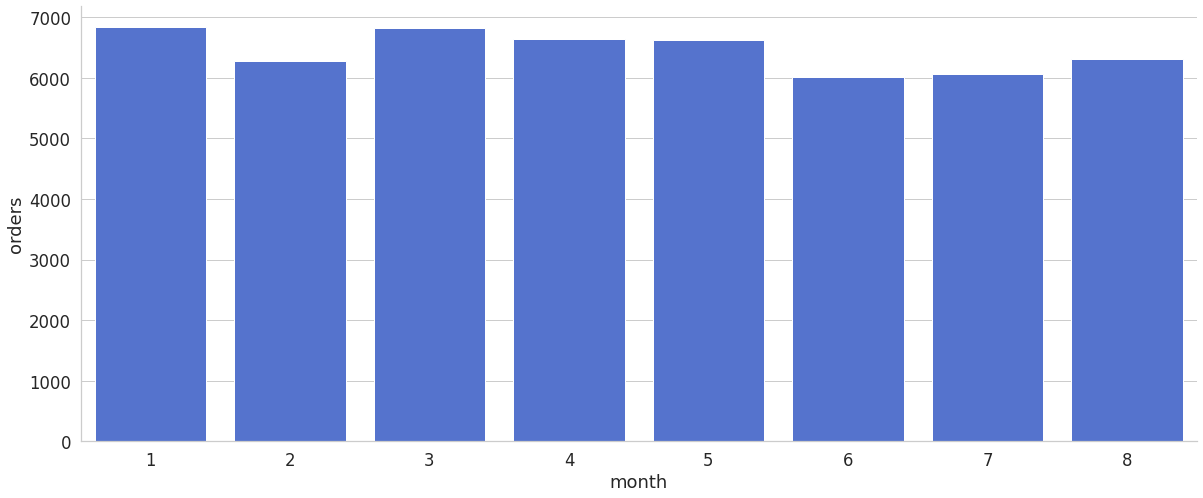

In [54]:
sns.barplot(data = orders_with_months_2018, x = 'month', y = 'orders', color = 'royalblue')
sns.despine()

Мы видим что заказы достаточно равномерно распределены во времени, не просматривается сезонность или какие-то яркие взлеты или падения в количестве заказов.

Назначим ранги Recency следующим образом:
- 1. Очень давние заказы. 1 календарный квартал.
- 2. Довольно давние заказы. 2 календарный квартал.
- 3. Недавние заказы. 3 календарный квартал.

**Определим значения рангов для Monetary**. Выясним, сколько потратил каждый пользователь и посмотрим на распределение этого значения.

In [55]:
customers_with_money = (orders_with_customers_2018
                        .merge(order_items, on = 'order_id', how = 'inner')
                        .groupby('customer_unique_id', as_index = False)
                        .agg({'price':'sum'})
                        .rename(columns = {'price':'total_price'})
                        .sort_values('total_price')
                       )
customers_with_money               

,customer_unique_id,total_price
36303,b38211bd797f4fdd81a98b9d1754b606,0.85
43580,d80730c15c647bc8f2ad77c908ba5ca9,0.85
10032,317cfc692e3f86c45c95697c61c853a6,2.20
41803,cf3839da0d9492ad151690b65f45d800,2.99
22138,6d6065917074c293416673faaba09336,3.00
...,...,...
48029,edde2314c6c30e864a128ac95d6b2112,4399.87
32772,a229eba70ec1c2abef51f04987deb7a5,4400.00
14724,48e1ac109decbb87765a3eade6854098,4590.00
14049,459bef486812aa25204be022145caa62,6729.00


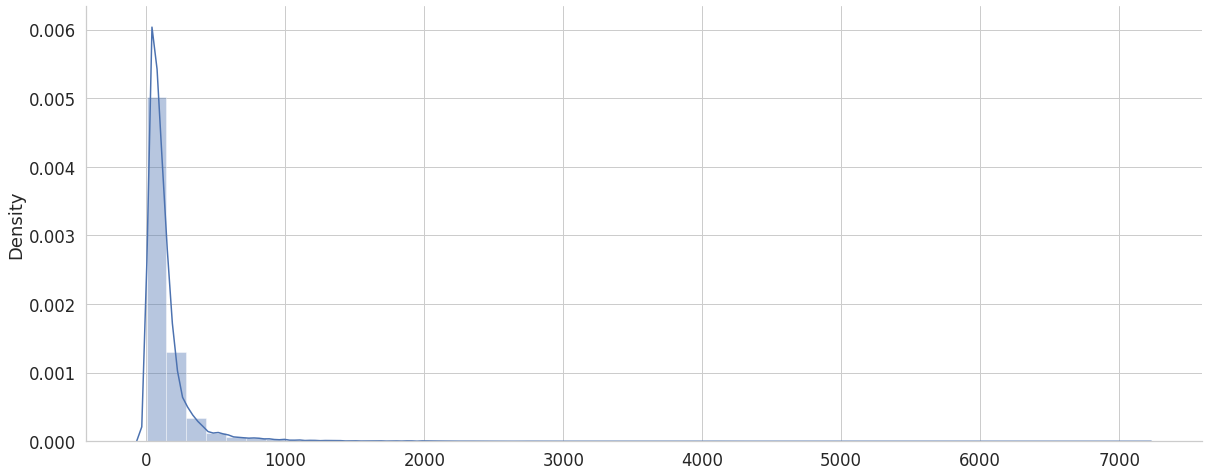

In [56]:
sns.distplot(x = customers_with_money.total_price)
sns.despine()

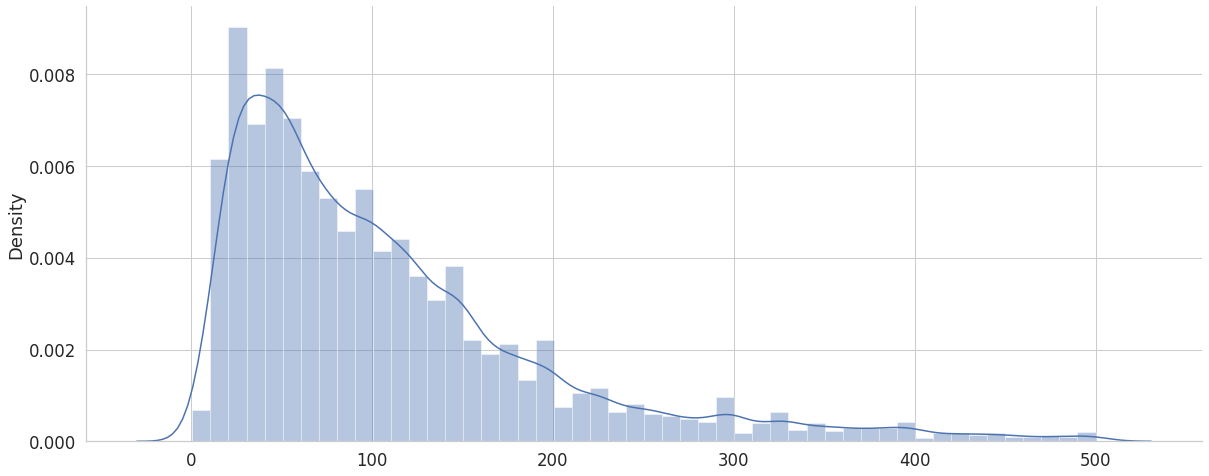

In [57]:
sns.distplot(x = customers_with_money.query('total_price < 500').total_price)
sns.despine()

Первое, что можно заметить - несоразмерно большие заказы стоимостью от 1000 и выше. Сделаем шаг в сторону и посмотрим на них подробней.

In [58]:
big_orders = (orders_with_customers_2018
                        .merge(order_items, on = 'order_id', how = 'inner')
                       )
big_orders['total_price'] = big_orders.order_item_id * big_orders.price
big_orders.query('total_price > 1000').head(50).sort_values('total_price', ascending = False)

,order_id,customer_unique_id,order_purchase_timestamp,month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price
1599,b239ca7cd485940b31882363b52e6674,ca27f3dac28fb1063faddd424c9d95fa,2018-07-29 08:39:48,7,1,dd113cb02b2af9c8e5787e8f1f0722f6,821fb029fc6e495ca4f08a35d51e53a5,2018-08-02 08:15:14,4059.00,104.51,4059.00
1731,cb418bb4b6115438d20b0141ed5bc9e0,9b11e010850a4045d2da80c7783fdbd1,2018-06-07 13:53:52,6,2,e74384c9363e768848854356a37c73f4,522620dcb18a6b31cd7bdf73665113a9,2018-06-21 14:20:16,1599.00,29.07,3198.00
2181,1d54db601b417ccdfd3b7071955e6cc7,bbeb907759ef5fc169099af3c88d535d,2018-04-27 05:57:39,4,1,6e729bd456c54469a9af4c8774f1eab7,039e6ad9dae79614493083e241147386,2018-05-04 10:29:50,3105.00,104.72,3105.00
4071,80d49171762a51f500bf6b774aa24617,34ff67eb3466a779b2f6b6fd56a3b953,2018-05-31 21:05:55,5,1,44c7b85d371365e52230e2e0efb8e0d8,edb1ef5e36e0c8cd84eb3c9b003e486d,2018-06-10 21:29:59,2749.65,38.22,2749.65
3436,4412d97cb2093633afa85f11db46316c,1b76903617af13189607a36b0469f6f3,2018-05-22 13:43:23,5,1,993ac19aa975075775c16ba15426f8be,9803a40e82e45418ab7fb84091af5231,2018-05-29 02:55:11,2499.75,12.00,2499.75
2444,e130d3f737127ae52681b9338aea9b64,bef3ce10ea5715fbcbcbe3b266ee94c5,2018-05-25 14:41:25,5,3,b008888e5e01a5c9da36306228e900d1,7681ef142fd2c19048da7430856b5588,2018-05-29 10:19:15,790.00,32.39,2370.00
618,947ee6ab639791b5711558a7e55cf98e,1a3a962a15f8c6ee0178e1102387d3cc,2018-06-11 22:04:34,6,1,12803e6c48756086227e39a8a2d2026b,f9244d45189d3a3605499abddeade7d5,2018-07-16 09:01:12,2139.99,83.13,2139.99
1460,b92aa81f74ab98a2f1a9cc5659f6edcf,02e8a66528e84b3ca6150d9b1e03a26f,2018-06-24 13:49:51,6,1,87feb07adc221a4c6cdf051ea1afd0ff,e882b2a25a10b9c057cc49695f222c19,2018-06-29 10:53:44,2110.00,48.57,2110.00
1015,8ddd6fc19a466ec0847fec42d69824c6,12ebfdb41392890f9d7a8de957274741,2018-05-19 18:43:01,5,1,87feb07adc221a4c6cdf051ea1afd0ff,e882b2a25a10b9c057cc49695f222c19,2018-05-24 18:58:35,2110.00,43.35,2110.00
2319,2ce3c61f3add382691fcad6a04f52680,1003a1d72627f1a71f255e239aaa4bfd,2018-05-10 15:24:26,5,2,46e24ce614899e36617e37ea1e4aa6ff,17f51e7198701186712e53a39c564617,2018-05-25 16:21:02,1050.00,185.73,2100.00


Я предполагал что в этих данных возможны аномалии, но если они и есть - невооруженным взглядом их заметить не удалось. Количество товаров выглядит вменяемо, стоимости товаров, пусть и удивительно несоразмерные другим товарам, также выглядят корректно. Если бы была возможность получить исходники со стоимостями в виде некого каталога, можно было бы проверить подробно. Но так как данный датасет - это всё, что у нас пока есть - смиримся с тем что наша компания продает как мелкие товары, так и значительно более крупные, и вернемся к определению границ метрики Monetary.

Не имея никакой дополнительной информации, будь то например маржинальность, складские запасы, себестоимость, добавленная стоимость и т.п., назначать границы приходится интуитивным образом. Глядя на графики, лично мне хочется провести 2 засечки - в районе значения 100 (отсекая большой пласт наименее "дорогих" заказов) и в районе значения 400 (отсекая наши самые крупные и редкие заказы).

Посмотрим на значения квантилей нашего распределения. 

In [59]:
customers_with_money.total_price.quantile(q = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95])

0.10     25.99
0.20     39.50
0.30     52.00
0.40     69.90
0.50     89.49
0.60    109.99
0.70    139.00
0.80    179.00
0.90    276.00
0.95    412.00
Name: total_price, dtype: float64

Как можно видеть, наши интуитивные предположения оказались близки к значениям медианы и 95-го процентиля. Отдавая дань математической статистике, примем эти величины как ориентиры для нашего распределения по метрике Monetary.

- 1. Заказы со стоимостью менее 89.49
- 2. Заказы со стоимостью в диапазоне от 89.50 до 411.99
- 3. Заказы со стоимостью от 412.00

In [60]:
# Запишем пограничные значения в переменные.
median = customers_with_money.total_price.median()
quant_95 = customers_with_money.total_price.quantile(q = 0.95)

Присвоим наши ранги каждому пользователю.

In [61]:
# Frequency. 
# 1 - сделал 1 заказ.
# 2 - сделал 2 заказа.
# 3 - сделал более 2х заказов.

# Cоздадим датафрейм для присвоения рангов.
customers_frequency = (orders_with_customers_2018
    .groupby('customer_unique_id')
    .agg({'order_id':'count'})
    .rename(columns = {'order_id':'orders_count'})
                      )
customers_frequency

,orders_count
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0004bd2a26a76fe21f786e4fbd80607f,1
00050ab1314c0e55a6ca13cf7181fecf,1
00053a61a98854899e70ed204dd4bafe,1
...,...
fff2ae16b99c6f3c785f0e052f2a9cfb,1
fff3e1d7bc75f11dc7670619b2e61840,1
fff5eb4918b2bf4b2da476788d42051c,1


In [62]:
customers_frequency['f_rank'] = '1'
customers_frequency['f_rank'] = customers_frequency['f_rank'].where(~(customers_frequency.orders_count > 1), other ='2')
customers_frequency['f_rank'] = customers_frequency['f_rank'].where(~(customers_frequency.orders_count > 2), other ='3')
customers_frequency = customers_frequency.drop(columns = 'orders_count')
customers_frequency

,f_rank
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0004bd2a26a76fe21f786e4fbd80607f,1
00050ab1314c0e55a6ca13cf7181fecf,1
00053a61a98854899e70ed204dd4bafe,1
...,...
fff2ae16b99c6f3c785f0e052f2a9cfb,1
fff3e1d7bc75f11dc7670619b2e61840,1
fff5eb4918b2bf4b2da476788d42051c,1


In [63]:
# Проверим количество присвоенных f_rank.
if check == customers_frequency.f_rank.value_counts().sum():
    print('Ok')
else:
    print('!!!ERROR!!!')

Ok


In [64]:
# Recency.

# Сделаем датафрейм на основе существующего, присвоив номерам месяцев нужные ранги.

customers_recency = orders_with_months_2018
customers_recency

,month,orders
0,1,6839
5,2,6286
1,3,6825
2,4,6647
3,5,6625
7,6,6017
6,7,6063
4,8,6310


In [65]:
customers_recency['r_rank'] = '1'
customers_recency['r_rank'] = customers_recency['r_rank'].where(~(customers_recency.month > 3), other = '2')
customers_recency['r_rank'] = customers_recency['r_rank'].where(~(customers_recency.month > 6), other = '3')
customers_recency

,month,orders,r_rank
0,1,6839,1
5,2,6286,1
1,3,6825,1
2,4,6647,2
3,5,6625,2
7,6,6017,2
6,7,6063,3
4,8,6310,3


In [66]:
# Удалим лишнюю колонку.
customers_recency = customers_recency.drop(columns = 'orders')
customers_recency

# Проверить внесенные данные можно визуально.

,month,r_rank
0,1,1
5,2,1
1,3,1
2,4,2
3,5,2
7,6,2
6,7,3
4,8,3


In [67]:
# Monetary

customers_monetary = customers_with_money
customers_monetary

,customer_unique_id,total_price
36303,b38211bd797f4fdd81a98b9d1754b606,0.85
43580,d80730c15c647bc8f2ad77c908ba5ca9,0.85
10032,317cfc692e3f86c45c95697c61c853a6,2.20
41803,cf3839da0d9492ad151690b65f45d800,2.99
22138,6d6065917074c293416673faaba09336,3.00
...,...,...
48029,edde2314c6c30e864a128ac95d6b2112,4399.87
32772,a229eba70ec1c2abef51f04987deb7a5,4400.00
14724,48e1ac109decbb87765a3eade6854098,4590.00
14049,459bef486812aa25204be022145caa62,6729.00


In [68]:
customers_monetary['m_rank'] = '1'
customers_monetary['m_rank'] = customers_monetary['m_rank'].where(~(customers_monetary.total_price >= median), other = '2')
customers_monetary['m_rank'] = customers_monetary['m_rank'].where(~(customers_monetary.total_price >= quant_95), other = '3')
customers_monetary = customers_monetary.drop(columns = {'total_price'})

In [69]:
# Проверка
if check == customers_monetary.shape[0]:
    print('Ok')
else:
    print('!!!ERROR!!!')
customers_monetary

Ok


,customer_unique_id,m_rank
36303,b38211bd797f4fdd81a98b9d1754b606,1
43580,d80730c15c647bc8f2ad77c908ba5ca9,1
10032,317cfc692e3f86c45c95697c61c853a6,1
41803,cf3839da0d9492ad151690b65f45d800,1
22138,6d6065917074c293416673faaba09336,1
...,...,...
48029,edde2314c6c30e864a128ac95d6b2112,3
32772,a229eba70ec1c2abef51f04987deb7a5,3
14724,48e1ac109decbb87765a3eade6854098,3
14049,459bef486812aa25204be022145caa62,3


Объединим полученные значения метрик и наконец сформируем наш RFM-score.

In [70]:
rfm = (orders_with_customers_2018
    .groupby('customer_unique_id', as_index = False)
    .agg({'month':'max'})
    .merge(customers_recency, on = 'month', how = 'left')
    .merge(customers_frequency, on = 'customer_unique_id', how = 'left')
    .merge(customers_monetary, on = 'customer_unique_id', how = 'left')
       )
rfm['month'] = rfm.r_rank + rfm.f_rank + rfm.m_rank
rfm = rfm.rename(columns = {'month':'rfm'})
rfm

,customer_unique_id,rfm,r_rank,f_rank,m_rank
0,0000366f3b9a7992bf8c76cfdf3221e2,212,2,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,211,2,1,1
2,0004bd2a26a76fe21f786e4fbd80607f,212,2,1,2
3,00050ab1314c0e55a6ca13cf7181fecf,211,2,1,1
4,00053a61a98854899e70ed204dd4bafe,112,1,1,2
...,...,...,...,...,...
51607,fff2ae16b99c6f3c785f0e052f2a9cfb,212,2,1,2
51608,fff3e1d7bc75f11dc7670619b2e61840,311,3,1,1
51609,fff5eb4918b2bf4b2da476788d42051c,313,3,1,3
51610,fff96bc586f78b1f070da28c4977e810,311,3,1,1


Итак, RFM-score присвоен каждому пользователю. Поработаем с полученными данными - аггрегируем, визуализируем, попробуем сделать некоторые предположения по дальнейшим действиям с этими группами.

In [71]:
rfm_count = (rfm.groupby('rfm')
             .agg({'customer_unique_id':'count'})
             .reset_index()
             .rename(columns = {'customer_unique_id':'number_of_customers'})
            )
rfm_count

,rfm,number_of_customers
0,111,10110
1,112,8577
2,113,884
3,121,52
4,122,275
5,123,42
6,131,1
7,132,6
8,133,3
9,211,9215


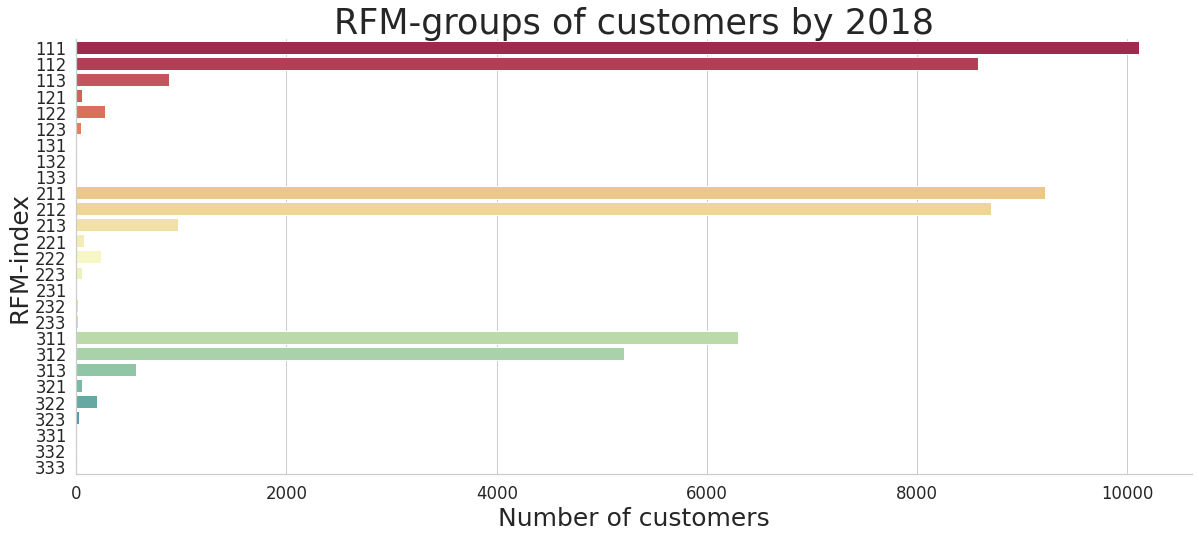

In [72]:
dx = sns.barplot(data = rfm_count, 
            x = 'number_of_customers', 
            y = 'rfm',
            palette =  'Spectral'
           )
dx.set_title('RFM-groups of customers by 2018', fontsize= 35)
dx.set_ylabel('RFM-index',fontsize= 25)
dx.set_xlabel('Number of customers',fontsize= 25)
sns.despine()

Очеивидно, визуализация несколько хромает от тех же причин, с которыми мы многократно сталкивались раньше - мало повторных заказов и крайне много однократных заказов. Однако, глядя на наши данные, попробуем сделать некоторые выводы. Размышления будут довольно абстрактными, так как не ясны ни специфика бизнеса, ни маркетинговые каналы и т.д. Однако, в общем виде хочется сказать о следующем:

- 1. Крайне много однократных заказов, причем как в категории недавних пользователей, так и в категории пользователей, которые оформили заказ много месяцев назад. На визуализации это все 9 самых длинных отрезков. Если наши продукты предполагают некоторое повторное возвращение клиента (а судя по данным, это скорее так, ведь есть и те пользователи, которые такие покупки все же совершают), то следует направить значительные ресурсы на то, чтобы клиент совершил хотя бы второй заказ. 
- 2. У нас очень большая вариативность признака Monetary. Допустим что товары со стоимостью более 400 - некий премиум-контент, и он и должен покупаться с такой динамикой. Однако больше половины наших заказов не дотягивают даже до 100. Возможно стоит подумать над тем, как увеличить среднюю стоимость заказа - проинформировать клиентов о том, какие еще товары у нас есть, проанализировать совершенные покупки и сделать таргретированную рассылку с сопутствующими товарами. Также может быть полезным проанализировать рынок на предмет наличия товаров, которые органично дополнили нашу линейку.
- 3. Регулярной клиенсткой базы у нас практически нет. Такой результат мог бы быть получен ввиду малого временного диапазона, хотя ранее сделанный анализ retention по 2017-му году позволяет предположить что и ранее динамика была аналогичная. Вопрос - почему наши клиенты с нами не остаются? Даже если приобретаемый нашими пользователями товар приобретается достаточно редко, чтобы не попасть в рамки нашего анализа - почему мы не можем предложить нашим пользователям другие товары, которые были бы им интересны? Нужно провести тщательную работу над стратегией для удержания наших лояльных пользователей - запустить программу лояльности, предоставить дополнительный какой-либо экслюзивный набор услуг, чтобы хотя бы эти пользователи перестали от нас уходить.

Назначать стандартные в индустрии "лейблы" для категорий пользователей на данной стадии я не стал умышленно. Наши данные настолько странные, что прежде чем определять для себя целевые сегменты и стратегию по ним, на мой взгляд нужно ответить на ряд глобальных стратегических вопросов, часть из которых была озвучена выше.

В итоге отправляемся в git, чтобы запушить данный файл в GitLab, а затем будем ждать ревью от Василия.

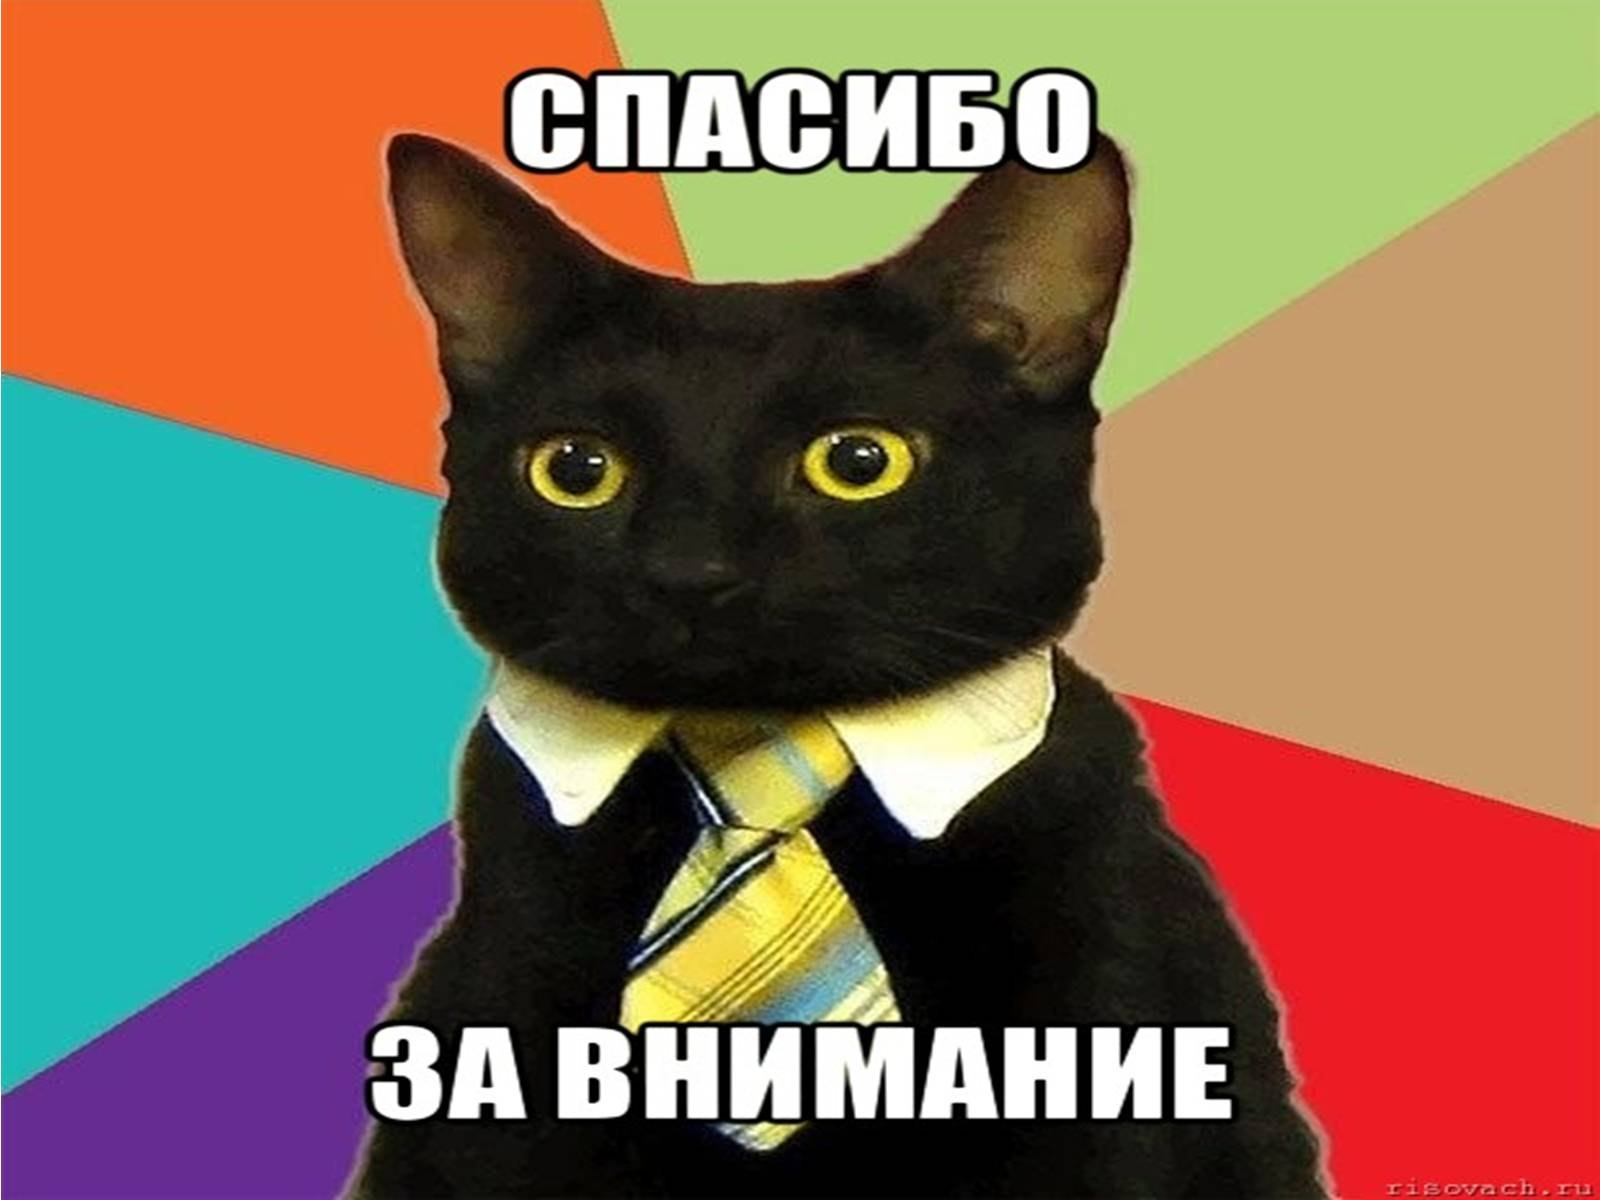

PS. Небольшой комментарий для ревьюера и случайного гостя. Я осознаю, что в некоторых местах понасоздавал совершенно избыточных переменных, и многие из созданных датафреймов были не нужны. Отчасти это продиктовано неоднозначностью поставленных задач - хотелось иметь сохраненные результаты на разных стадиях процесса, чтобы не приходилось переписывать большие объемы кода при корректировках. Также в некоторых местах я занимал лишнюю память умышленно, так как проект этот предназначен в том числе для портфолио, и в нем хотелось сделать процессы максимально прозрачными, пусть и более затратными по ресурсам. 